In [52]:
# Run with GPU

# load and define globals

import torch
from IPython.display import clear_output
import torchvision
import cv2
import numpy as np
import pandas as pd
from torch import nn
from torch import optim
import torch.nn.functional as F
from torch.autograd import Variable
from torch.utils.data import DataLoader, TensorDataset
from torchvision import transforms
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
import os
import random
import seaborn as sns

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

batch_size = 2**10 # 2**10

image_size = (100, 100, 3) # 100, 100, 3
encoding_size = 16 # 64

def to_img(x):
    return np.moveaxis(x.numpy() * 255, 0, -1).astype(np.uint8)

# Function to get the length-to-width ratio of the largest contour in an image
def getLWR(img):
    # Convert image to grayscale if it has more than one channel
    if img.shape[2] > 1:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    # Add a constant border to the image
    img = cv2.copyMakeBorder(img, 10, 10, 10, 10, cv2.BORDER_CONSTANT, value=0)
    # Apply binary thresholding
    _, img = cv2.threshold(img, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    # Invert image if the background is white
    if img[0, 0] == 255:
        img = cv2.bitwise_not(img)
    # Find contours in the image
    contours, _ = cv2.findContours(img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    # Get the largest contour by area
    contour = max(contours, key=cv2.contourArea)
    # Get dimensions of the minimum area rectangle enclosing the contour
    w, h = cv2.minAreaRect(contour)[1]
    # Return the length-to-width ratio
    return max(w, h) / min(w, h)

def getShapeIndex(img):
      # Convert image to grayscale if it has more than one channel
    if img.shape[2] > 1:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    # Add a constant border to the image
    img = cv2.copyMakeBorder(img, 10, 10, 10, 10, cv2.BORDER_CONSTANT, value=0)
    # Apply binary thresholding
    _, img = cv2.threshold(img, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    # Invert image if the background is white
    if img[0, 0] == 255:
        img = cv2.bitwise_not(img)
    # Find contours in the image
    contours, _ = cv2.findContours(img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    # Get the largest contour by area
    contour = max(contours, key=cv2.contourArea)
    # Initialize variables to store the max width and corresponding height
    max_width = 0
    max_height = 0
    point1 = None
    point2 = None
    # Iterate through each pair of points in the contour
    for i in range(len(contour)):
        for j in range(i + 1, len(contour)):
            # Calculate the distance between the two points in both x and y directions
            dx = contour[j][0][0] - contour[i][0][0]
            dy = contour[j][0][1] - contour[i][0][1]
            # If the distance in the x direction (width) is the largest we've seen
            width = abs(dx)
            if width > max_width:
                max_width = width
                max_height = abs(dy)  # The corresponding height (vertical distance)
                point1 = contour[i][0]
                point2 = contour[j][0]
    return max_height / max_width

def getMeanNonBlackColor(img):
  data = img.reshape(-1, img.shape[-1])
  data = data[np.array([np.all(i != [0,0,0]) for i in data])]
  return np.mean(data, axis = 0)

def getRedness(img):
  # image should be rgb
  data = img.reshape(-1, img.shape[-1])
  data = data[np.array([np.all(i != [0,0,0]) for i in data])]
  # redness is distance from (160,20,20)
  distances = np.linalg.norm(data - [160,20,20], axis = 1)
  distances = 255 - np.mean(distances)
  return distances


img_transform = transforms.Compose([transforms.ToTensor()])

def loader(path):
    return img_transform(cv2.imread(path)[:,:,range(image_size[2])])

class VAE(nn.Module):
    def __init__(self):
        super(VAE, self).__init__()
        self.fc1 = nn.Linear(np.prod(image_size), 400)
        self.fc21 = nn.Linear(400, encoding_size)
        self.fc22 = nn.Linear(400, encoding_size)
        self.fc3 = nn.Linear(encoding_size, 400)
        self.fc4 = nn.Linear(400, np.prod(image_size))

    def encode(self, x):
        h1 = F.relu(self.fc1(x))
        return self.fc21(h1), self.fc22(h1)

    def reparametrize(self, mu, logvar):
        std = logvar.mul(0.5).exp_()
        if torch.cuda.is_available():
            eps = torch.cuda.FloatTensor(std.size()).normal_()
        else:
            eps = torch.FloatTensor(std.size()).normal_()
        eps = Variable(eps)
        return eps.mul(std).add_(mu)

    def decode(self, z):
        h3 = F.relu(self.fc3(z))
        return F.sigmoid(self.fc4(h3))

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparametrize(mu, logvar)
        return self.decode(z), mu, logvar

reconstruction_function = nn.MSELoss(reduction='sum')

def loss_function(recon_x, x, mu, logvar):
    """
    recon_x: generating images
    x: origin images
    mu: latent mean
    logvar: latent log variance
    """
    BCE = reconstruction_function(recon_x, x)  # loss
    # loss = 0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
    KLD_element = mu.pow(2).add_(logvar.exp()).mul_(-1).add_(1).add_(logvar)
    KLD = torch.sum(KLD_element).mul_(-0.5)
    # KL divergence
    return BCE + KLD


def compute_LWRs_from_original(original_flat, model, device, image_size=(3, 100, 100)):
    """
    Given a flattened original image, return LWRs for both original and decoded version.

    Parameters:
        original_flat: flattened original image [3*H*W] (torch.Tensor or np.ndarray can both work)
        model: your VAE model with encode/decode methods
        device: torch.device (e.g., 'cuda' or 'cpu')
        image_size: expected image shape, default (3, 100, 100)

    Returns:
        (LWR_original, LWR_decoded)
    """

    # Ensure tensor type
    if isinstance(original_flat, np.ndarray):
        original_tensor = torch.tensor(original_flat, dtype=torch.float32)
    else:
        original_tensor = original_flat

    # ---------------- Original LWR ----------------
    img = original_tensor.reshape(image_size).numpy()            # [C, H, W]
    img = np.transpose(img, (1, 2, 0))                  # [H, W, C]
    img = np.clip(img, 0, 1)                       # Clamp before scaling
    img = (img * 255).astype(np.uint8)
    LWR_original = getLWR(img)

    # ---------------- Decoded LWR ----------------
    # Run through VAE
    input_tensor = original_tensor.view(1, -1).to(device)
    mu, logvar = model.encode(input_tensor)
    encoded = model.reparametrize(mu, logvar)
    decoded = model.decode(encoded)

    # Convert to image
    decoded = decoded.detach().cpu().view(image_size)            # [C, H, W]
    decoded_img = decoded.numpy()
    decoded_img = np.transpose(decoded_img, (1, 2, 0))          # [H, W, C]
    decoded_img = np.clip(decoded_img, 0, 1)
    decoded_img = (decoded_img * 255).astype(np.uint8)
    LWR_decoded = getLWR(decoded_img)

    return LWR_original, LWR_decoded


def compute_LWRs_from_pair(img1, img2, model, device, image_size=(3, 100, 100)):
    # Ensure torch tensor
    if isinstance(img1, np.ndarray):
        img1 = torch.tensor(img1, dtype=torch.float32)
    if isinstance(img2, np.ndarray):
        img2 = torch.tensor(img2, dtype=torch.float32)

    # Compute original LWRs
    def process_individual_image(img):
        img = img.reshape(image_size).numpy()
        img = np.transpose(img, (1, 2, 0))  # [H, W, C]
        img = np.clip(img, 0, 1)
        img = (img * 255).astype(np.uint8)
        return getLWR(img)

    LWR1 = process_individual_image(img1)
    LWR2 = process_individual_image(img2)
    LWR_mean = 0.5 * (LWR1 + LWR2)

    # Encode both images
    z1_mu, _ = model.encode(img1.view(1, -1).to(device))
    z2_mu, _ = model.encode(img2.view(1, -1).to(device))

    z_avg = (z1_mu + z2_mu) / 2

    # Decode average
    decoded = model.decode(z_avg).detach().cpu().view(image_size)
    decoded = decoded.numpy()
    decoded = np.transpose(decoded, (1, 2, 0))
    decoded = np.clip(decoded, 0, 1)
    decoded = (decoded * 255).astype(np.uint8)
    LWR_decoded = getLWR(decoded)

    return LWR_mean, LWR_decoded

In [2]:
from google.colab import drive
drive.mount('/content/drive', force_remount = True)
os.chdir('/content/drive/Shareddrives/Strawberries/Image experiment/')

Mounted at /content/drive


In [3]:
# load data, create train/test sets, and initialize model
images = torch.load('fullImages.pt')
random_seed = 1

trainKey = np.genfromtxt(str(random_seed) + '_trainKey.csv', delimiter=',', skip_header=0)
testKey = np.genfromtxt(str(random_seed) + '_testKey.csv', delimiter=',', skip_header=0)
trainKey = trainKey >= 0
testKey = testKey >= 0

trainImages, testImages = images[trainKey], images[testKey]

trainDataloader = DataLoader(TensorDataset(trainImages), batch_size=batch_size, shuffle=True)
testDataloader = DataLoader(TensorDataset(testImages), batch_size=batch_size, shuffle=True)

# load VAE
model = VAE()
model.load_state_dict(torch.load(str(random_seed) + "_vae_" + str(encoding_size) + ".pth"))
model.to(device)

VAE(
  (fc1): Linear(in_features=30000, out_features=400, bias=True)
  (fc21): Linear(in_features=400, out_features=16, bias=True)
  (fc22): Linear(in_features=400, out_features=16, bias=True)
  (fc3): Linear(in_features=16, out_features=400, bias=True)
  (fc4): Linear(in_features=400, out_features=30000, bias=True)
)

In [4]:
# load image here
original_image_1 = images[0]
original_image_2 = images[1]

In [5]:
# encode and decode image

image_1 = original_image_1.view(1, -1).to(device)  # Ensure image is on GPU and properly reshaped
mu, logvar = model.encode(image_1)
encoded = model.reparametrize(mu, logvar)
decoded_image_1 = model.decode(encoded)
decoded_image_1 = decoded_image_1.view(1, -1)
decoded_image_1 = to_img(decoded_image_1.detach().cpu().view(image_size[::-1]))  # Move back to CPU for processing


image_2 = original_image_2.view(1, -1).to(device)
mu, logvar = model.encode(image_2)
encoded = model.reparametrize(mu, logvar)
decoded_image_2 = model.decode(encoded)
decoded_image_2 = decoded_image_2.view(1, -1)
decoded_image_2 = to_img(decoded_image_2.detach().cpu().view(image_size[::-1]))

<ipython-input-1-7b93f0fa38f8>:124: UserWarning: The torch.cuda.*DtypeTensor constructors are no longer recommended. It's best to use methods such as torch.tensor(data, dtype=*, device='cuda') to create tensors. (Triggered internally at /pytorch/torch/csrc/tensor/python_tensor.cpp:78.)
  eps = torch.cuda.FloatTensor(std.size()).normal_()


In [6]:
type(decoded_image_2)

numpy.ndarray

In [7]:
# Get original LWRs
image_1 = images[0].reshape(3, 100, 100)      # Shape: [C, H, W]
image_1_np = image_1.permute(1, 2, 0).numpy() # Shape: [H, W, C] for OpenCV
image_1_np = (image_1_np * 255).astype(np.uint8)
LWR_1 = getLWR(image_1_np)

image_2 = images[1].reshape(3, 100, 100)
image_2_np = image_2.permute(1, 2, 0).numpy()
image_2_np = (image_2_np * 255).astype(np.uint8)
LWR_2 = getLWR(image_2_np)

LWR_ori_avg = 0.5*(LWR_1+LWR_2)


# Get decoded LWRs
decoded_image_1 = decoded_image_1.reshape(3, 100, 100)
decoded_image_1_np = np.transpose(decoded_image_1, (1, 2, 0))
decoded_image_1_np = (decoded_image_1_np * 255).astype(np.uint8)
decoded_LWR_1 = getLWR(decoded_image_1_np)

decoded_image_2 = decoded_image_2.reshape(3, 100, 100)
decoded_image_2_np = np.transpose(decoded_image_2, (1, 2, 0))
decoded_image_2_np = (decoded_image_2_np * 255).astype(np.uint8)
decoded_LWR_2 = getLWR(decoded_image_2_np)

LWR_dec_avg = 0.5*(decoded_LWR_1+decoded_LWR_2)

In [8]:
print("Original LWR: " + str(LWR_ori_avg))
print("Decoded LWR: " + str(LWR_dec_avg))

Original LWR: 1.0583622337747511
Decoded LWR: 1.0


Observed mean difference: 0.003263
Empricial mean difference of pwds: 1.8277262228328014e-06
Empirical p-value: 0.000000
More extreme instances: 0


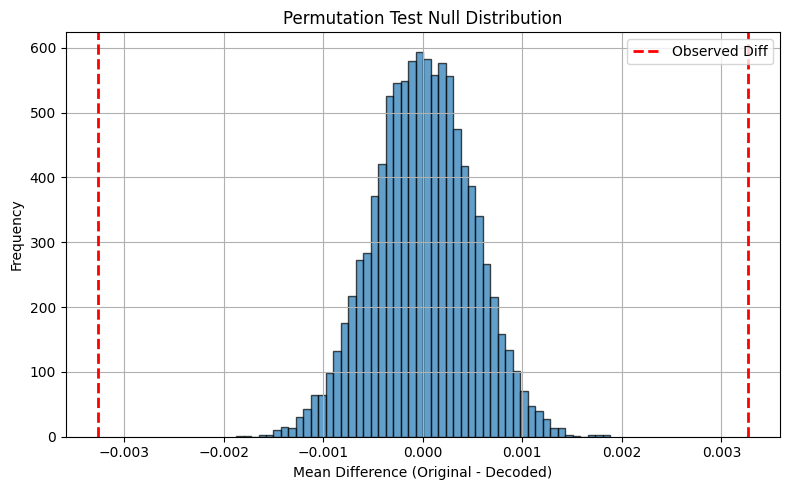

In [51]:
import matplotlib.pyplot as plt

# Paired comparsion
# Full data: 13922 (original_LWR, processed_LWR)
# Total possible permutation = 2^13922 --> too large
LWR_originals = []
LWR_decodeds = []

for i in range(13922):
    orig = images[i]
    LWR_o, LWR_d = compute_LWRs_from_original(orig, model, device)
    LWR_originals.append(LWR_o)
    LWR_decodeds.append(LWR_d)

LWR_originals = np.array(LWR_originals)
LWR_decodeds = np.array(LWR_decodeds)


# Permutation test
# H0: LWR_(encoding+decoding) = LWR_original on average
observed_diff = np.mean(LWR_originals - LWR_decodeds)
n_permutations = 10000 # 10k
n_samples = len(LWR_originals)
perm_diffs = np.zeros(n_permutations)

for i in range(n_permutations):
    # Random mask: for each pair, flip a coin (0 = no swap, 1 = swap)
    flip = np.random.rand(n_samples) < 0.5
    x_perm = np.where(flip, LWR_decodeds, LWR_originals)
    y_perm = np.where(flip, LWR_originals, LWR_decodeds)

    perm_diffs[i] = np.mean(x_perm - y_perm)

# 3. Empirical p-value (two-sided)
p_value = np.sum(np.abs(perm_diffs) >= np.abs(observed_diff))/n_permutations

print(f"Observed mean difference: {observed_diff:.6f}")
print("Empricial mean difference of pwds:", np.mean(perm_diffs))
print(f"Empirical p-value: {p_value:.6f}")
print("More extreme instances:", np.sum(np.abs(perm_diffs) >= np.abs(observed_diff)))


plt.figure(figsize=(8, 5))
# Plot histogram of permuted differences
plt.hist(perm_diffs, bins=50, edgecolor='black', alpha=0.7)
plt.axvline(observed_diff, color='red', linestyle='dashed', linewidth=2, label='Observed Diff')
plt.axvline(-observed_diff, color='red', linestyle='dashed', linewidth=2)

plt.title("Permutation Test Null Distribution")
plt.xlabel("Mean Difference (Original - Decoded)")
plt.ylabel("Frequency")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

Std of original: 0.1267955694703472
Std of decoded: 0.1202733219202349
Std of differences: 0.057611703580302175


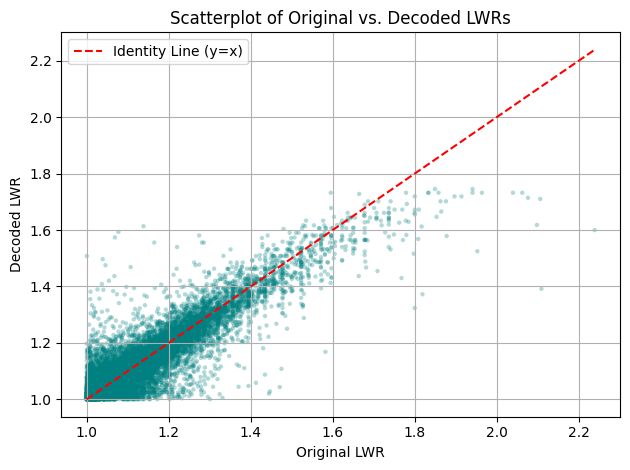

In [10]:
print("Std of original:", np.std(LWR_originals))
print("Std of decoded:", np.std(LWR_decodeds))
print("Std of differences:", np.std(LWR_originals - LWR_decodeds))

# Scatterplot
plt.figure()
plt.scatter(LWR_originals, LWR_decodeds, alpha=0.3, s=10, color='teal', edgecolor='none')
plt.plot([min(LWR_originals), max(LWR_originals)],
         [min(LWR_originals), max(LWR_originals)],
         color='red', linestyle='dashed', label='Identity Line (y=x)')

plt.xlabel("Original LWR")
plt.ylabel("Decoded LWR")
plt.title("Scatterplot of Original vs. Decoded LWRs")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

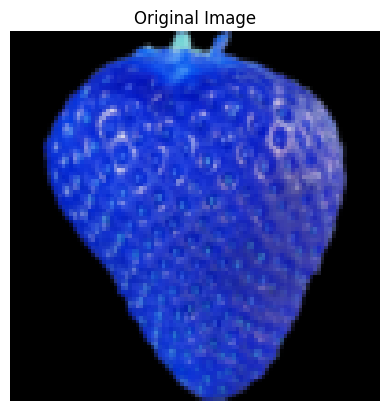

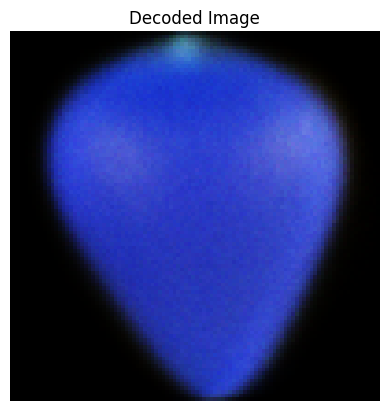

30000
<class 'numpy.ndarray'>


In [ ]:
orig = images[500]
if hasattr(orig, 'numpy'):
    orig = orig.numpy()
orig_img = orig.reshape(3, 100, 100)             # [C, H, W]
orig_img = np.transpose(orig_img, (1, 2, 0))     # [H, W, C]
orig_img = (orig_img * 255).astype(np.uint8)     # Convert to uint8 for display

plt.imshow(orig_img)
plt.title("Original Image")
plt.axis('off')
plt.show()

if isinstance(orig, np.ndarray):
    orig_tensor = torch.tensor(orig, dtype=torch.float32)
else:
    orig_tensor = orig

decoded_image = orig_tensor.view(1, -1).to(device)  # Ensure image is on GPU and properly reshaped
mu, logvar = model.encode(decoded_image)
encoded = model.reparametrize(mu, logvar)
decoded_image = model.decode(encoded)
decoded_image = decoded_image.view(1, -1)
decoded_image = to_img(decoded_image.detach().cpu().view(image_size[::-1]))  # Move back to CPU for processing

plt.imshow(decoded_image)
plt.title("Decoded Image")
plt.axis('off')
plt.show()

print(orig.size)
print(type(decoded_image))

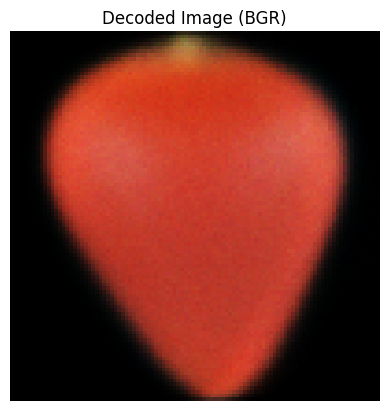

In [ ]:
# prompt: convert decoded_image from rgb to bgr and display

import matplotlib.pyplot as plt
decoded_image_bgr = cv2.cvtColor(decoded_image, cv2.COLOR_RGB2BGR)
plt.imshow(decoded_image_bgr)
plt.title("Decoded Image (BGR)")
plt.axis('off')
plt.show()

In [88]:
# Interpolability experiment
# Shuffle indices and group into non-overlapping pairs
n_pairs = len(images) // 2
indices = torch.randperm(len(images))
pairs = [(indices[i].item(), indices[i + 1].item()) for i in range(0, 2 * n_pairs, 2)]

# Compute LWR for each image in the pair and their average
def compute_LWR(image_flat):
    image_tensor = image_flat.view(3, 100, 100)
    image_np = image_tensor.numpy().transpose(1, 2, 0)
    image_np = (np.clip(image_np, 0, 1) * 255).astype(np.uint8)
    return getLWR(image_np)

mean_LWRs = []
for i, j in pairs:
    lwr_i = compute_LWR(images[i])
    lwr_j = compute_LWR(images[j])
    mean_LWRs.append((lwr_i + lwr_j) / 2)

In [98]:
import copy
decoded_LWRs = copy.deepcopy(mean_LWRs)
random.shuffle(decoded_LWRs)

In [99]:
decoded_LWRs = []

for i, j in pairs:
    # Get flattened original images
    img_i = images[i].view(1, -1).to(device)  # shape [1, 30000]
    img_j = images[i].view(1, -1).to(device)

    # Encode each image to latent space
    mu_i, logvar_i = model.encode(img_i)
    mu_j, logvar_j = model.encode(img_j)

    # Use mean embeddings (mu) — you can try sampling with reparametrize too
    z_i = mu_i
    z_j = mu_j

    # Average latent vectors
    z_avg = (z_i + z_j) / 2

    # Decode the average embedding
    decoded = model.decode(z_avg).view(3, 100, 100).detach().cpu().numpy()

    # Prepare image for LWR
    decoded_img = np.transpose(decoded, (1, 2, 0))          # [H, W, C]
    decoded_img = np.clip(decoded_img, 0, 1) * 255
    decoded_img = decoded_img.astype(np.uint8)

    # Compute LWR
    decoded_LWR = getLWR(decoded_img)
    decoded_LWRs.append(decoded_LWR)

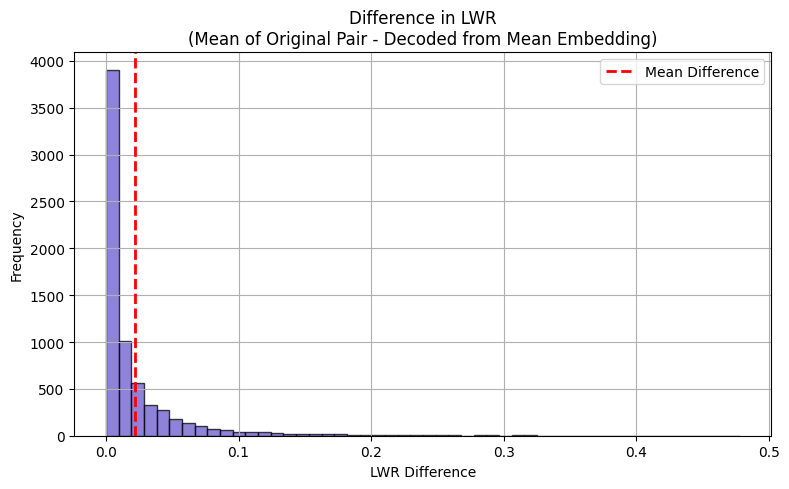

Mean of differences: 0.021955749417226274


In [100]:
diffs = (np.array(mean_LWRs) - np.array(decoded_LWRs)) ** 2

# Plot histogram of differences
plt.figure(figsize=(8, 5))
plt.hist(diffs, bins=50, color='slateblue', edgecolor='black', alpha=0.75)
plt.axvline(np.mean(diffs), color='red', linestyle='dashed', linewidth=2, label='Mean Difference')
plt.title("Difference in LWR\n(Mean of Original Pair - Decoded from Mean Embedding)")
plt.xlabel("LWR Difference")
plt.ylabel("Frequency")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

print("Mean of differences:", np.mean(diffs))

In [59]:
# Permutation test
# paired data: 6961 (mean LWR of original pair, LWR decoded from mean embedding)
LWR_mean = []
LWR_decodeds = []

# Form non-overlapping pairs
indices = torch.randperm(len(images))
n_pairs = len(images) // 2

for i in range(n_pairs):
    idx1 = indices[2 * i]
    idx2 = indices[2 * i + 1]

    img1 = images[idx1]
    img2 = images[idx2]

    # Compute (mean LWR of original pair, LWR of decoded image from avg embedding)
    LWR_o, LWR_d = compute_LWRs_from_pair(img1, img2, model, device)

    LWR_mean.append(LWR_o)
    LWR_decodeds.append(LWR_d)

LWR_mean = np.array(LWR_mean)
LWR_decoded = np.array(LWR_decodeds)


# H0: 0.5*LWR_(image1+image2) = LWR_(decoded(0.5*(embedding1+embedding2)))
observed_diff = np.mean(LWR_mean - LWR_decoded)
n_permutations = 10000 #10k
n_samples = len(LWR_mean)
perm_diffs = np.zeros(n_permutations)

for i in range(n_permutations):
    # Random mask: for each pair, flip a coin (0 = no swap, 1 = swap)
    flip = np.random.rand(n_samples) < 0.5
    x_perm = np.where(flip, LWR_decodeds, LWR_mean)
    y_perm = np.where(flip, LWR_mean, LWR_decodeds)

    perm_diffs[i] = np.mean(x_perm - y_perm)

# 3. Empirical p-value (two-sided)
p_value = np.sum(np.abs(perm_diffs) >= np.abs(observed_diff))/n_permutations

print(f"Observed mean difference: {observed_diff:.6f}")
print("Empricial mean difference:", np.mean(perm_diffs))
print(f"Empirical p-value: {p_value:.6f}")
print("More extreme instances:", np.sum(np.abs(perm_diffs) >= np.abs(observed_diff)))

Observed mean difference: 0.028186
Empricial mean difference: -2.286343397760307e-06
Empirical p-value: 0.000000
More extreme instances: 0


In [54]:
# Testing
LWR_mean = np.array([1.2, 1.0, 1.1, 0.9])
LWR_decoded = np.array([1.1, 0.9, 1.2, 1.0])
observed_diff = np.mean(LWR_mean - LWR_decoded) #0
np.random.seed(100)
flip = np.random.rand(4) < 0.5
print(flip)

x_perm = np.where(flip, LWR_decoded, LWR_mean)
print(x_perm)
y_perm = np.where(flip, LWR_mean, LWR_decoded)
print(y_perm)
perm_diff = np.mean(x_perm - y_perm)
print(perm_diff)

# Our example
print(perm_diffs)

[False  True  True False]
[1.2 0.9 1.2 0.9]
[1.1 1.  1.1 1. ]
-5.551115123125783e-17
[ 4.22353011e-04 -5.31364485e-04  5.03444181e-04 ...  2.43425431e-04
  9.59542314e-05  1.60545485e-04]
